# NCM, HVC Lesion "Effect Size" Analysis

This notebook is Leah's 6/28/22 work on quantifying "effect size" in different ways.

When running this notebook with the `SAVE_FIGS` flag set to True, the EPS files of the figures will be saved to `FIGDIR = "notebooks/figures/svg_originals"`.

The statistics reported in the paper are printed out in the corresponding section, and (when possible) printed in the same format as in used in the paper. Statistics are rounded to 2 decimal places, and p-values are rounded to 4 decimal places (so that we can report 3 decimal places in the paper, or "< 0.001") 

## 1 Reading the data

Reading the data is facilitated by the class `zf_data.Tsvk`, which provides some helper methods to compute quantities used in the paper/figures. The name "Tsvk" refers to the term $T^{sv}_k$ from the methods used to compute $p(\mathrm{int}|s,v,k)$ --- that is the probability that subject $s$ interrupts a particular vocalizer $v$, given that it has seen $k$ informative trials of that vocalizer. 

Note that this data structure is not required for any analyses, since the raw data can be loaded directly from `zebra-finch-memory-lesions/data/behavior/TrialData.csv` and processed however you choose. However, it can be far more convenient to use this structure since it predefines methods used to perform the analyses found in the paper.

We also provide a helper functino `zf_data.load_trials()` for loading the TrialData.csv, which returns a pandas DataFrame containing all operant trials for all subjects.

```python
from zf_data import load_trials
df = load_trials()
```

## 2 Using the Tsvk data structure

A `Tsvk` instance is initialized with (1) a pandas DataFrame containing a filtered subset of operant trials, and (2) a value of `k_max`, the largest informative trial bin to include in the analysis.

```python
from zf_data import Tsvk
tsvk = Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

### Methods

Here are some of the helper methods `Tsvk` defines

* `tsvk.p(subject, vocalizer, k)`
    > Averages $p(\mathrm{int}|s,v,k)$ over vocalizers. Use `Tsvk.re.p(...)` and `Tsvk.nore.p(...)` to restrict it to either Re or NoRe vocalizers respectively.

* `tsvk.re.p_by_k()`, `Tsvk.nore.p_by_k()`
    > for each $k$, estimates $p(\mathrm{int}|Re,k)$ and $p(\mathrm{int}|NoRe,k)$ by jackknifing over subjects. These are used to produce the group average learning curves in Figure 3A and 3B.

* `tsvk.re.odds_by_subjects(k)`, `Tsvk.nore.odds_by_subjects(k)`
    > for each $k$, computes odds of interrupting Re or NoRe vocalizers of each subject

* `tsvk.logOR_by_subjects(k)`
    > for each $k$, compute
    $$
    \mathrm{logOR}(s, k)=\mathrm{log}(Odds(\mathrm{int}|s,NoRe,k)) - \mathrm{log}(Odds(\mathrm{int}|s,Re,k))
    $$
    for each subject, returning it in a pandas DataFrame

* `tsvk.logOR()`
    > Computes $\mathrm{logOR}(k)$ for $k \in \{0, .., k_{max}\}$. At each $k$, the estimate and SEM is estimated using a jackknife procedure over subjects, returning it in a pandas DataFrame. The condition $\mathrm{logOR}(k) > 0$ is tested with a one-sided paired t-test over subjects. The Benjamini-Hochberg false discovery correction used in the paper should be applied after calling this method.

* `tsvk.fisher_exact()`
    > Computes the result of a Fisher exact test on the entire DataFrame, with the following contingency matrix. The Fisher exact test returns the estimate of $\mathrm{OR}=\frac{ad}{bc}$, 95% confidence bounds on the estimate, and a p-value. 

|         |Interruptions|Waits|
|---------|:-:|:-:|
|NoRe     | a | c |
|Re       | b | d |

### Note on caching results

Computing the quantities used in the paper can be relatively slow (10s of seconds). Each `Tsvk` instance caches the result of most of its methods when they are called once, so that re-running a cell happens relatively instantaneously.

Sometimes multiple figures/analyses operate on the same subset of data (e.g. the top and bottom figures of Figure 3A and 3B). To avoid re-instantiating a `Tsvk` instance for each analysis (which would cause all the computations to be re-run), a function called `get_or_create_Tsvk` is defined in this notebook which restores a previous `Tsvk` instance if the dataframe and k_max parameter are identical.

## 3 Typical analysis pattern


The pattern used in this notebook is usually:

1. Instantiate a Tsvk object for one or more ranges of data (e.g. S1 & prelesion), e.g.

```python
tsvk = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
```

2. Compute some quantity or quantities of interest, e.g.

```python
re_probabilities = tsvk.re.p_by_k()
nore_probailities = tsvk.nore.p_by_k()
```

3. Plot or perform statistics on the returned quantities, e.g.

```python
import matplotlib.pyplot as plt
plt.errorbar(re_probabilities.k, re_probabilities.logOR, y_err=2 * re_probabilities.SE)
plt.errorbar(nore_probabilities.k, nore_probabilities.logOR, y_err=2 * nore_probabilities.SE)
```

In [1]:
import os
import sys

In [2]:
os.chdir('/Users/frederictheunissen/Code/zebra-finch-memory-lesions/')

In [3]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels
import statsmodels.api as sm
import statsmodels.regression
import statsmodels.formula.api as smf
from matplotlib.gridspec import GridSpec
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from scipy.stats import permutation_test

from zf_data import Tsvk, load_trials
from zf_data.load_data import load_lesion_summary_table
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    plot_pecking_test_data,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
from zf_data.stats import false_discovery, likelihood_ratio_test, two_to_one_tail, jackknife
from zf_data.utils import parse_p, setup_mpl_params
from zf_data.constants import *

## Notebook Settings

In [4]:
# Set matplotlib axes to default grey using zf_data.utils Kevin wrote
setup_mpl_params()

In [5]:
# This code is for troubleshooting / writing.  It is an ipython "magic" command that will autoreload modules.
# This makes it possible to edit various functions in a text editor, then call the function again and
# get a different behavior, because the module is reloaded each time the function is called.
# Not sure it is necessary unless active editing is happening.

%load_ext autoreload
%autoreload 2

In [6]:
SAVE_FIGS = False  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)  # pathlib Path() function turns string into Path object 

# Create the folder for figure outputs
FIGDIR.mkdir(parents=True, exist_ok=True)  #from Pathlib .mkdir function not os .mkdir function

# little helper function for saving later... 
def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

In [7]:
# JNeurosci column sizes in cm, see https://www.jneurosci.org/content/information-authors
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}

### Helper functions

In [8]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}

def test_get_or_create_Tsvk(df: pd.DataFrame):
    backup = get_or_create_Tsvk.cache.copy()
    get_or_create_Tsvk.cache = {}
    t1 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t2 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t3 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=12)
    t4 = get_or_create_Tsvk(df[(df.LesionStage == "postlesion") & (df.VocalizerSet == "S2")], k_max=12)
    
    assert t1 is t2
    assert t1 is not t3
    assert t2 is not t3
    assert t1 is not t4
    assert t2 is not t4
    print("Tests pass")
    
    get_or_create_Tsvk.cache = backup

## Load data

In [9]:
df = load_trials()

In [10]:
test_get_or_create_Tsvk(df)

Tests pass


## Fig 4-E Effect Size on MEMORY (/Recall)

I will plot a new panel for Fig 4 or a replacement for Fig 4 B or C.  I'll call it Fig 4-E for now for "effect size."  This plot is "effect size as a function of informative trials", and it compares performance on Set 1 (previously learned stimuli) between NCM lesioned birds and non-NCM lesioned birds (both HVC and control birds are lumped together). 

The calculation is similar to a d' measurement, except instead of d' being a measure of discriminability between two stimuli, " d' " here is the difference in the (mean) odds ratios between NCM lesioned and ~NCM lesioned birds' performance.  This is the calculation, which will be performed at each k value: 

d' =  <u>2( mean of log(OR)~NCM - mean of log(OR)NCM )</u>

       sqrt( variance~NCM^2 + varianceNCM^2 )
         
This way, the measurement of "effect size" is normalized by the standard deviation (it's not really a psychophysical measurement, but it's calculated the same way as d')

In [11]:
## First I will plot the performance of birds on Set 1 on days 4 and 5 of the learning ladder.
## This is Fig 3B lower panel

def figure3b_odds(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()
    
    # shaded_line() is a function found in zf_data.plotting it uses fill_between() 
    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
    
    print("Figure 3B (Bottom)")
    print("------------------")
    print("   Red dotted = HVC; Black dotted = control; Green = NCM;")
    print("   Blue = average of all with 2 SEM shaded")
    print(f"  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")

    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            }
        )
    
    ax.set_ylabel("OR", fontsize=10)
    ax.set_xlabel("Informative Trials", fontsize=10)
    plt.legend(["Avg", 'Avg', "NCM", "HVC", "CTRL"])

Figure 3B (Bottom)
------------------
   Red dotted = HVC; Black dotted = control; Green = NCM;
   Blue = average of all with 2 SEM shaded
  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; logOR = 2.40, t(20) = 3.61, p = 0.001 (***)


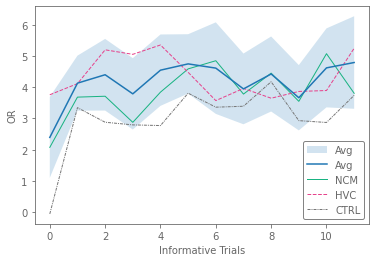

In [12]:
figure3b_odds()

In [13]:
## Now I will try a Fig3B_odds but lump HVC and control together
def fig3b_odds_NCM_vs_nonNCM(ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    # the next two lines are used for the blue line average and shaded area SE 
    # shaded_line() is a function found in zf_data.plotting it uses fill_between() 
    
    logOR = tsvk.logOR()
    
    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
    
    print("Figure 3B Bottom Modified")
    print(" Last two days of song ladder")
    print(" logOR versus infomative trials k")
    print("-----------------------------------")
    print(f"  Specifically days 6v6-d2/8v8-d2 for pre-lesion learning of S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
    print(f"   Black dotted = control and HVC; Green = NCM;")
    print(f"   Blue = average of all with 2 SEM shaded")
    
    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            plot_name = treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            plot_name = "CTRL"  # TODO change this to new color?  in zf_data.constants
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
        
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[plot_name],
                "color": COLORMAP[plot_name],
                "zorder": -1,
                "linewidth": 1
            }
        )
    
    ax.set_ylabel("OR", fontsize=10)
    ax.set_xlabel("Informative Trials", fontsize=10)
    plt.legend(["Avg", 'Avg', "NCM", "HVC+CTRL"])

Figure 3B Bottom Modified
 Last two days of song ladder
 logOR versus infomative trials k
-----------------------------------
  Specifically days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; logOR = 2.40, t(20) = 3.61, p = 0.001 (***)
   Black dotted = control and HVC; Green = NCM;
   Blue = average of all with 2 SEM shaded


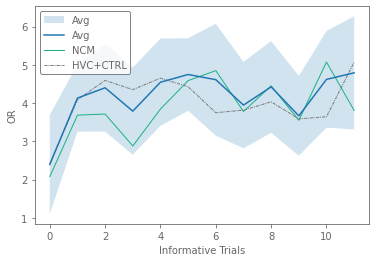

In [14]:
fig3b_odds_NCM_vs_nonNCM()

In [15]:
# Now here is Fig 4B
def figure4b(ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure 4B")
    print("---------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", "HVC", "CTRL", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()
        
        if isinstance(treatment, str):
            shaded_line(
                logOR["k"], 
                logOR["logOR"], 
                2 * logOR["SE"],
                ax=ax,
                line_kwargs={
                    "color": COLORMAP[treatment],
                    "linestyle": LINEMAP[treatment]
                }
            )
        else:
            print(f"Computing combined treatments, {treatment}")
            print(f"==========================================")
        
        pvalues = logOR["pvalue"]
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being re-exposed to S1")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()
        ax.set_ylabel("OR", fontsize=10)
        ax.set_xlabel("Informative Trials", fontsize=10)
        plt.legend(["NCM", "", "HVC", "", "CTRL",""])

Figure 4B
---------
 The NCM group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; NCM: logOR = -0.54, t(9) = -0.68, p = 0.742
    k=1; NCM: logOR = 1.04, t(9) = 2.71, p = 0.012 (*)

 The HVC group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; HVC: logOR = 1.42, t(6) = 4.05, p = 0.003 (**)
    k=1; HVC: logOR = 3.50, t(6) = 7.41, p < 0.001 (***)

 The CTRL group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; CTRL: logOR = 1.24, t(3) = 1.19, p = 0.160
    k=1; CTRL: logOR = 1.96, t(3) = 2.80, p = 0.034 (*)

Computing combined treatments, ('HVC', 'CTRL')
 The ('HVC', 'CTRL') group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; ('HVC', 'CTRL'): logOR = 1.36, t(10) = 3.32, p = 0.004 (**)
    k=1; ('HVC', 'CTRL'): logOR

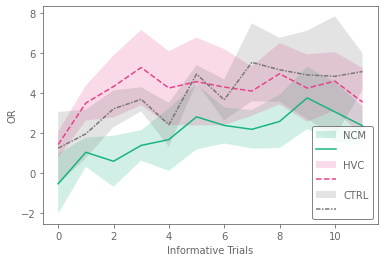

In [16]:
figure4b()

In [21]:
# Now let's modify Fig4b to combine HVC and control birds.  Above, they are plotted as HVC = red and ctrl = grey
# Here I will combine HVC and control into one grey line (leaving NCM green)

def fig4b_modified(ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure 4B modified")
    print("-------------------")
    print("Grey = control and HVC; Green = NCM" )
    print("-------------------------------------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            plot_name = treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            plot_name = "HVC+CTRL"  # For colors in zf_data.constants
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR(mode='fisher-exact')
        
        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[plot_name],
                "linestyle": LINEMAP[plot_name]
            },
            fill_kwargs={
                "facecolor": COLORFILL[plot_name]
            }
        )
        
        pvalues = logOR["pvalue"]
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being re-exposed to S1")
        print("-----------------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f},{parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f},  {parse_p(pvalues[1])}")
        print()
    
    ax.set_xlabel("Uninterrupted Trials", fontsize=10)
    
    draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
    ax.set_ylim(-2, 7)
    draw_k_axis(k_max=11, ax=ax)
    ax.set_ylabel(r"$OR^{\dagger}$", fontsize=8)
    border(ax, 1, 0, 0, 0)
    ax.legend(["NCM", "", "HVC+CTRL", ""], fontsize=6)

Figure 4B modified
-------------------
Grey = control and HVC; Green = NCM
-------------------------------------
 The NCM group after lesion, being re-exposed to S1
-----------------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; NCM: logOR = -0.10,p = 0.827
    k=1; NCM: logOR = 1.38,  p < 0.001 (***)

 The ('HVC', 'CTRL') group after lesion, being re-exposed to S1
-----------------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; ('HVC', 'CTRL'): logOR = 2.01,p < 0.001 (***)
    k=1; ('HVC', 'CTRL'): logOR = 3.60,  p < 0.001 (***)



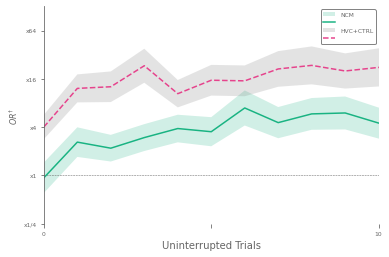

In [22]:
fig4b_modified()

In [13]:
# OK at last, lets plot the unitless "effect size" versus informative trials

def fig4e(ax: plt.Axes = None):
    """Plots effect size of NCM lesion during initial stage of ladder AFTER lesion
        NCM birds are compared to "control", which in this case is HVC + CTRL condition birds lumped together
        
        effect size = d' = (sqrt(2) * difference_in_logORs_CTRL-NCM) / normalized_variance
        
        specifically: 
                        difference_in_logORs_CTRL-NCM = logOR_CTRL - logOR_NCM
                        normalized_variance =  sqrt(var_NCM * (NCM_dof+1) + var_CTRL * (CTRL_dof+1) / 
                                                                ((NCM_dof+1) + (CTRL_dof+1)))
        """
    if ax is None:
        ax = plt.gca()

    print("Figure 4e : NCM lesion effect on recall")
    print("-----------------------------------------")
    print(" effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / ")
    print("                  / normalized_std ")
    print(" ")
    print(" Set 1 vocalizers")

    # create two separate tsvk instances, one for control group one for NCM

    tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    logOR_NCM = tsvk_NCM.logOR(mode='fisher-exact')
    
    treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
    for t in ("HVC", "CTRL"):
        treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & treatment_filter
    ], k_max=11)
    logOR_CTRL = tsvk_control.logOR(mode='fisher-exact')
    
    # difference of the logORs
    diff_logOR = logOR_CTRL["logOR"]-logOR_NCM["logOR"]
    
    # normalization term
    #nNCM = logOR_NCM["dof"] + 1
    #nCTRL = logOR_CTRL["dof"] + 1
    nNCM=10
    nCTRL=11
    var_NCM = logOR_NCM["SE"]**2 * nNCM 
    var_CTRL = logOR_CTRL["SE"]**2 * nCTRL
    norm_var = np.sqrt((var_NCM * nNCM + var_CTRL * nCTRL) / (nNCM + nCTRL))
    norm_se = norm_var/np.sqrt(nNCM + nCTRL)
    
    # Take the mean of norm_var
    mean_std = norm_var.mean()
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var
    SE_average = np.sqrt(2)*norm_se/norm_var
    
    shaded_line(
        logOR_NCM["k"], 
        d_prime, 
        2*SE_average, 
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )
    ax.plot([0, 11], [0, 0], color='k', linestyle='--')
    ax.set_ylabel("Effect Size (d')", fontsize=10)
    ax.set_xlabel("Informative Trials", fontsize=10)
    return logOR_NCM["k"], d_prime, SE_average

Figure 4e : NCM lesion effect on recall
-----------------------------------------
 effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / 
                  / normalized_std 
 
 Set 1 vocalizers


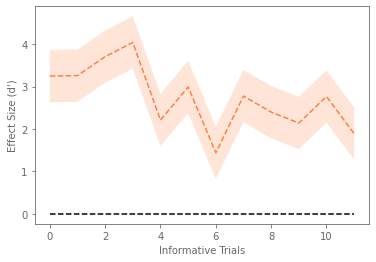

In [14]:
k, d_prime_S1, SE_S1 = fig4e()

## Fig 5-E Effect Size on LEARNING

This plot is the same as above, except that now I'm working with performance on Set 2, which are songs that the birds did not learn before lesion.

In [22]:
# Original Fig 5b for comparison
def figure5b(ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    print("Figure 5B")
    print("------------------")
    for treatment in ["NCM", "HVC", "CTRL"]:
        print(COLORMAP[treatment] + " is " + treatment)
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[treatment],
                "linestyle": LINEMAP[treatment]
            },
        )

        pvalues = logOR["pvalue"]        
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being first exposed to S2")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()
    ax.set_ylabel("OR", fontsize=10)
    ax.set_xlabel("Informative Trials", fontsize=10)
    plt.legend(["NCM", "", "HVC", "", "CTRL", ""])

Figure 5B
------------------
#19b382 is NCM
 The NCM group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; NCM: logOR = -0.84, t(9) = -3.53, p = 0.997
    k=1; NCM: logOR = 0.04, t(9) = 0.09, p = 0.463

#e6438c is HVC
 The HVC group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=3
    k=0; HVC: logOR = -0.70, t(6) = -1.82, p = 0.940
    k=1; HVC: logOR = 0.44, t(6) = 0.86, p = 0.211

#777777 is CTRL
 The CTRL group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; CTRL: logOR = -0.63, t(3) = -2.16, p = 0.940
    k=1; CTRL: logOR = 0.77, t(3) = 1.71, p = 0.093



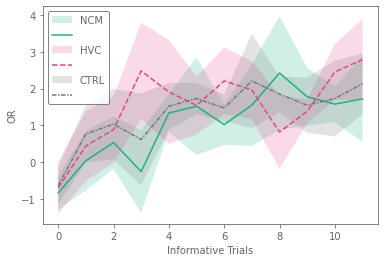

In [23]:
figure5b()

In [19]:
# Figure 5b with control and HVC groups merged
def fig5b_modified(ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    print("Figure 5B modified: logOR by k")
    print("--------------------------------")
    for treatment in ["NCM", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
            plot_name = treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            plot_name = "HVC+CTRL"  # For colors in zf_data.constants
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR(mode='fisher-exact')

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[plot_name],
                "linestyle": LINEMAP[plot_name]
            },
            fill_kwargs={
                "facecolor": COLORFILL[plot_name]
            }
        )

        pvalues = logOR["pvalue"]        
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being first exposed to S2")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f},  {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f},  {parse_p(pvalues[1])}")
        print()
        
    ax.set_xlabel("Uninterrupted Trials", fontsize=10)
    
    draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
    ax.set_ylim(-2, 7)
    draw_k_axis(k_max=11, ax=ax)
    ax.set_ylabel(r"$OR^{\dagger}$", fontsize=8)
    border(ax, 1, 0, 0, 0)
    ax.legend(["NCM", "", "HVC+CTRL", ""], fontsize=6)

Figure 5B modified: logOR by k
--------------------------------
 The NCM group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; NCM: logOR = -0.72,  p = 0.004 (**)
    k=1; NCM: logOR = -0.35,  p = 0.134

 The ('HVC', 'CTRL') group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; ('HVC', 'CTRL'): logOR = 0.47,  p = 0.023 (*)
    k=1; ('HVC', 'CTRL'): logOR = 0.04,  p = 0.889



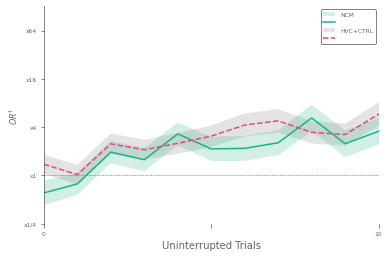

In [20]:
fig5b_modified()

In [15]:
# Now for Figure 5e, which will be effect of NCM lesion on LEARNING (compare to MEMORY/RECALL)

def fig5e(ax: plt.Axes = None):
    """Plots effect size of NCM lesion on learning a new vocalizer set
        NCM birds are compared to "control", which in this case is HVC + CTRL condition birds lumped together
        
        effect size = d' = (sqrt(2) * difference_in_logORs_CTRL-NCM) / normalized_variance
        
        specifically: 
                        difference_in_logORs_CTRL-NCM = logOR_CTRL - logOR_NCM
                        normalized_variance =  sqrt(var_NCM * (NCM_dof+1) + var_CTRL * (CTRL_dof+1) / 
                                                                ((NCM_dof+1) + (CTRL_dof+1)))
        """
    
    if ax is None:
        ax = plt.gca()

    print("Figure 5e : NCM lesion effect on learning")
    print("-----------------------------------------")
    print(" effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / ")
    print("                  / normalized_variance ")
    print(" ")
    print(" Set 2 vocalizers")

    # create two separate tsvk instances, one for control group one for NCM

    tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    logOR_NCM = tsvk_NCM.logOR(mode='fisher-exact')
    
    treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
    for t in ("HVC", "CTRL"):
        treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & treatment_filter
    ], k_max=11)
    logOR_CTRL = tsvk_control.logOR(mode='fisher-exact')
    
    # difference of the logORs
    diff_logOR = logOR_CTRL["logOR"]-logOR_NCM["logOR"]
    
    # normalization term
    #nNCM = logOR_NCM["dof"] + 1
    #nCTRL = logOR_CTRL["dof"] + 1
    nNCM = 10
    nCTRL = 11
    var_NCM = logOR_NCM["SE"]**2 * nNCM 
    var_CTRL = logOR_CTRL["SE"]**2 * nCTRL
    norm_var = np.sqrt((var_NCM * nNCM + var_CTRL * nCTRL) / (nNCM + nCTRL))
    norm_se = norm_var/np.sqrt(nNCM + nCTRL)
    
    # Take the mean of norm_var
    mean_std = norm_var.mean()
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var
    SE_average = np.sqrt(2)*norm_se/norm_var
        
    shaded_line(
        logOR_NCM["k"], 
        d_prime, 
        2*SE_average, 
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )
    ax.plot([0, 11], [0, 0], color='k', linestyle='--')
    ax.set_ylabel("Effect Size (d')", fontsize=10)
    ax.set_xlabel("Informative Trials", fontsize=10)
    return logOR_NCM["k"], d_prime, SE_average

Figure 5e : NCM lesion effect on learning
-----------------------------------------
 effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / 
                  / normalized_variance 
 
 Set 2 vocalizers


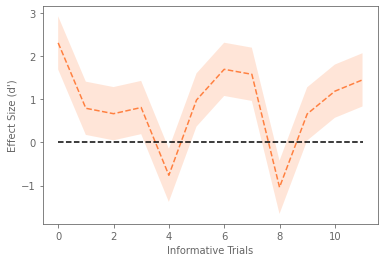

In [16]:
k, d_prime_S2, SE_S2 = fig5e()


Figure Dimensions 16.60cm x 5.00cm
Figure 4B modified
-------------------
Grey = control and HVC; Green = NCM
-------------------------------------
 The NCM group after lesion, being re-exposed to S1
-----------------
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; NCM: logOR = -0.10,p = 0.827
    k=1; NCM: logOR = 1.38,  p < 0.001 (***)

 The ('HVC', 'CTRL') group after lesion, being re-exposed to S1
-----------------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; ('HVC', 'CTRL'): logOR = 2.01,p < 0.001 (***)
    k=1; ('HVC', 'CTRL'): logOR = 3.60,  p < 0.001 (***)

Figure 5B modified: logOR by k
--------------------------------
 The NCM group after lesion, being first exposed to S2
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; NCM: logOR = -0.72,  p = 0.004 (**)
    k=1; NCM: logOR = -0.35,  p = 0.134

 The ('HVC', 'CTRL') group after lesion, being first exposed to S2
--------
  the smallest bin k where log

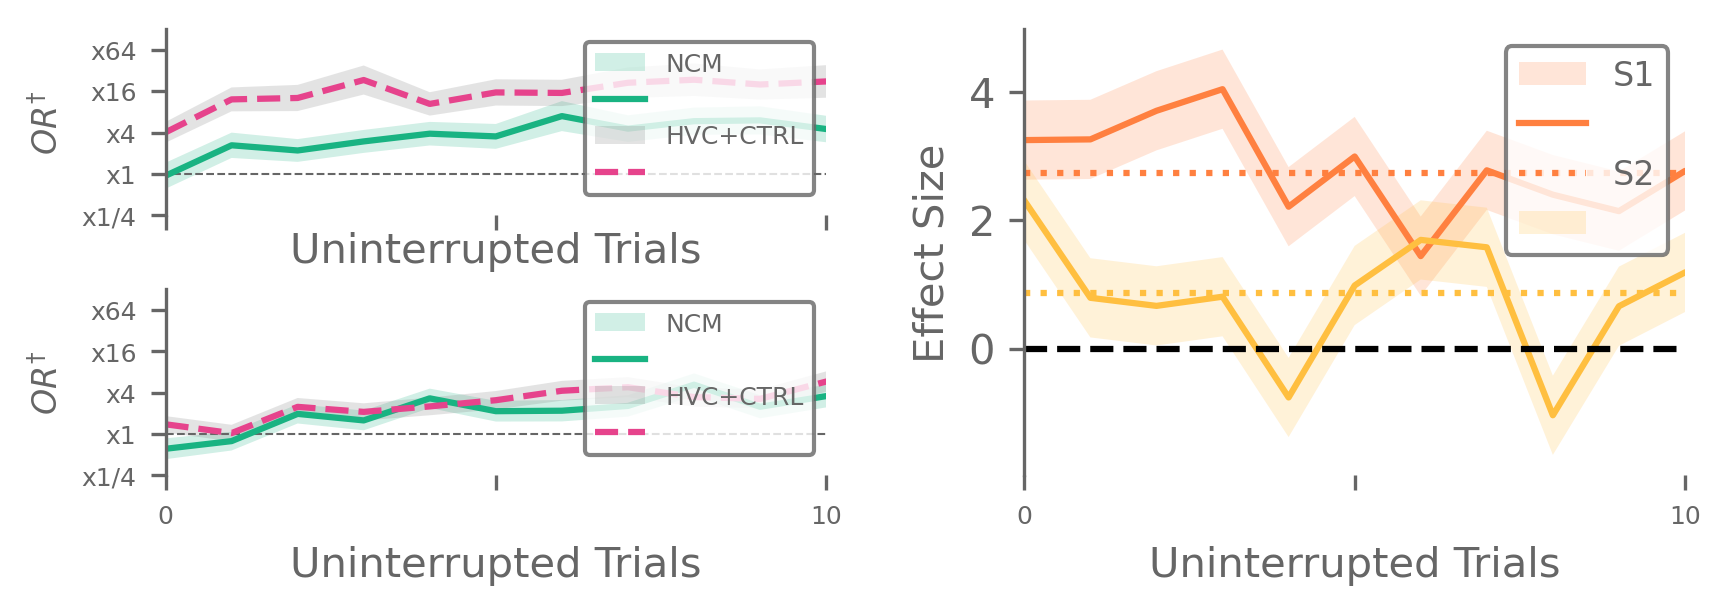

In [25]:
fig = figure_cm(COL2 - 1, 5, dpi=300)
hspace = 0.4
wspace = 0.3
gridspec_kw = {"hspace": hspace, "wspace": wspace}

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes = fig.subplots(2, 2, sharex=True, sharey= 'col', gridspec_kw=gridspec_kw)


fig4b_modified(axes[0][0])
fig5b_modified(axes[1][0])

gs = axes[0, 1].get_gridspec()
# remove the underlying axes
axes[0][1].remove()
axes[1][1].remove()

ax = fig.add_subplot(gs[:, 1])

shaded_line(
        k, 
        d_prime_S1, 
        2*SE_S1, 
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": '-',
        }
    )
ax.plot(k, np.mean(d_prime_S1)*np.ones(k.shape), color = [1.0, 0.5, 0.25], linestyle = ':' )
print('Mean effect size for S1', np.mean(d_prime_S1), '+-', 2*np.std(d_prime_S1)/np.sqrt(len(d_prime_S1)))

shaded_line(
        k, 
        d_prime_S2, 
        2*SE_S2, 
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.75, 0.25],
            
            "linestyle": '-',
        }
    )
ax.plot(k, np.mean(d_prime_S2)*np.ones(k.shape), color = [1.0, 0.75, 0.25], linestyle = ':' )
print('Mean effect size for S2', np.mean(d_prime_S2), '+-', 2*np.std(d_prime_S2)/np.sqrt(len(d_prime_S2)))

ax.set_ylabel("Effect Size", fontsize=10)
ax.set_xlabel("Uninterrupted Trials", fontsize=10)
ax.plot([0, 10], [0, 0], linestyle='--', color='k')
draw_k_axis(k_max=11, ax=ax)
border(ax, 1, 0, 0, 0)
ax.legend(["S1", "", "S2",""], fontsize=8)

In [26]:
fig.savefig(savedir("fig5_effectSize_new.svg"), format="svg", bbox_inches="tight")

In [ ]:
def d_prime_by_hand(logOR_by_subj_CTRL, logOR_by_subj_NCM):
    
    """returns a single value for d_prime from two arrays of of logORs, ctrl and NCM
    
        degrees of freedom are HARD CODED and this calculation should not be used elsewhere
        
        logOR_by_subjs input parameters are extracted from tsvk.logOR_by_subjects(k) objects.
        example: tsvkobj = tsvk.logOR_by_subjects(k)    ## must chose a k value
                 logOR_by_subj = tsvkobj['logOR']
    """
    
    mean_NCM, SE_NCM = jackknife(logOR_by_subj_NCM, np.mean)
    mean_ctrl, SE_ctrl = jackknife(logOR_by_subj_CTRL, np.mean)
    
    diff_logOR = mean_ctrl-mean_NCM
    
    # normalization term
    # note that dof is HARD CODED for control versus NCM groups 
    nNCM = 9 + 1    # 9 dof for NCM subjects
    nCTRL = 10 + 1  # 10 dof for ctrl and HVC subjects combined
    var_NCM = SE_NCM**2 * nNCM 
    var_CTRL = SE_ctrl**2 * nCTRL
    norm_var = np.sqrt(var_NCM * nNCM + var_CTRL * nCTRL / (nNCM + nCTRL))
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var

    return d_prime

In [ ]:
def permuted_d_prime(tsvk_ctrl, tsvk_ncm):
    """ Performs exhaustive permutation test over calculations of d_prime using logOR_by_subjects
        Function loops over informative trial bins k in tsvk_ctrl, tsvk_ncm
        Depends on lgj function d_prime_by_hand() and scipy.stats.permutation_test()

        Inputs
        -------
        tsvk_ctrl, tsvk_ncm : tsvk objects, which must have the same k    
            
        Returns
        -------
        result : pd.DataFrame
            A pandas dataframe with 4 columns, "k", "d_prime", "pvalue", "null_distribution"
    
            k : int
                The informative trial bins k
            d_prime : float
                The d_prime calculation for the original set of logOR values across subjects,
                performed by the function d_prime_by_hand
            pvalue : float
                Calculated by permutation_test()
            null_distribution : array
                All d_prime values for every permutation (for each k)
    """
    if tsvk_ctrl.k_max != tsvk_ncm.k_max:
        raise ValueError("k values for tsvk structures must match")
    
    d_primes = []
    pvalues = []
    null_distributions = []
    
    k = tsvk_ctrl.k_max + 1    # returns maximum k value in the tsvk, which starts from 0
    for x in range(k):
        logOR_ctrl = tsvk_ctrl.logOR_by_subjects(x)
        logOR_ncm = tsvk_ncm.logOR_by_subjects(x)
        
        logOR_ctrl_by_subj = logOR_ctrl['logOR']
        logOR_ncm_by_subj = logOR_ncm['logOR']
        
        permute = permutation_test((logOR_ncm_by_subj,logOR_ctrl_by_subj),
                                   d_prime_by_hand,
                                   n_resamples=np.inf, # make this smaller to shorten computation
                                   alternative='two-sided')
        d_primes.append(permute.statistic)
        pvalues.append(permute.pvalue)
        null_distributions.append(permute.null_distribution)
        
    return pd.DataFrame({
            "k": tsvk_ctrl.k,
            "d_prime": d_primes,
            "pvalue": pvalues,
            "null_distribution" : null_distributions,
        })

In [ ]:
# In this cell I run the permutation test in *advance* for EffectFig() below.
# this is because the permutation tests take ~30 min and I don't want to call this every time I 
# change something small in the figure (color or whatever)

tsvk_NCM = get_or_create_Tsvk(df[
    (df.LesionStage == "postlesion")
    & (df.VocalizerSet == "S1")
    & (df.SubjectTreatment == "NCM")
], k_max=11)
logOR_NCM = tsvk_NCM.logOR()
    
treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
for t in ("HVC", "CTRL"):
    treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
    (df.LesionStage == "postlesion")
    & (df.VocalizerSet == "S1")
    & treatment_filter
], k_max=11)

# permutation test
permutes_memory = permuted_d_prime(tsvk_control, tsvk_NCM)

learn_tsvk_NCM = get_or_create_Tsvk(df[
    (df.LesionStage == "postlesion")
    & (df.VocalizerSet == "S2")
    & (df.SubjectTreatment == "NCM")
], k_max=11)
learn_logOR_NCM = learn_tsvk_NCM.logOR()
    
learn_tsvk_control = get_or_create_Tsvk(df[
    (df.LesionStage == "postlesion")
    & (df.VocalizerSet == "S2")
    
    & treatment_filter
], k_max=11)

# permutation test
permutes_learning = permuted_d_prime(learn_tsvk_control, learn_tsvk_NCM)

In [ ]:
def EffectFig(ax: plt.Axes = None):
    """Plots effect size of NCM lesion during initial stage of ladder AFTER lesion
        NCM birds are compared to "control", which in this case is HVC + CTRL condition birds lumped together
        
        effect size = d' = (sqrt(2) * difference_in_logORs_CTRL-NCM) / normalized_variance
        
        specifically: 
                        difference_in_logORs_CTRL-NCM = logOR_CTRL - logOR_NCM
                        normalized_variance =  sqrt(var_NCM * (NCM_dof+1) + var_CTRL * (CTRL_dof+1) / 
                                                                ((NCM_dof+1) + (CTRL_dof+1)))
                                                                
        
        """
    if ax is None:
        ax = plt.gca()
        ax.hlines(0, 0, 12, colors=AX_COLOR, linestyles='--',)

    print("Figure 'Effect Size' : NCM lesion effect on recall and learning")
    print("---------------------------------------------------------------")
    print(" effect size = (sqrt(2) * difference_in_logORs_CTRL-NCM) / ")
    print("                  / normalized_variance ")
    print(" ")
    print(" Set 1 vocalizers (recall) = orange")
    print(" Set 2 vocalizers (learning) = yellow")

    # First plot the memory task with Set 1 data
    # create two separate tsvk instances, one for control group one for NCM

    tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    logOR_NCM = tsvk_NCM.logOR()
    
    treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
    for t in ("HVC", "CTRL"):
        treatment_filter |= df.SubjectTreatment == t
    
    tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & treatment_filter
    ], k_max=11)
    logOR_CTRL = tsvk_control.logOR()
    
    # difference of the logORs
    diff_logOR = logOR_CTRL["logOR"]-logOR_NCM["logOR"]
    
    # normalization term
    nNCM = logOR_NCM["dof"] + 1
    nCTRL = logOR_CTRL["dof"] + 1
    var_NCM = logOR_NCM["SE"]**2 * nNCM 
    var_CTRL = logOR_CTRL["SE"]**2 * nCTRL
    norm_var = np.sqrt((var_NCM * nNCM + var_CTRL * nCTRL) / (nNCM + nCTRL))
    
    # effect size of NCM lesion on memory
    d_prime = (np.sqrt(2) * diff_logOR) / norm_var
    
    # TODO : replace code cell above with the permutation test call here
    
    
    shaded_line(
        logOR_NCM["k"], 
        d_prime, 
        permutes_memory['pvalue'], # TODO ask frederic
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.5, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )
    
# Now for Figure 5e, which will be effect of NCM lesion on LEARNING (compare to MEMORY/RECALL)

    learn_tsvk_NCM = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == "NCM")
    ], k_max=11)
    learn_logOR_NCM = learn_tsvk_NCM.logOR()
    
    learn_tsvk_control = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & treatment_filter
    ], k_max=11)
    learn_logOR_CTRL = learn_tsvk_control.logOR()
    
    # difference of the logORs
    learn_diff_logOR = learn_logOR_CTRL["logOR"]-learn_logOR_NCM["logOR"]
    
    # normalization term
    learn_nNCM = learn_logOR_NCM["dof"] + 1
    learn_nCTRL = learn_logOR_CTRL["dof"] + 1
    learn_var_NCM = learn_logOR_NCM["SE"]**2 * learn_nNCM 
    learn_var_CTRL = learn_logOR_CTRL["SE"]**2 * learn_nCTRL
    learn_norm_var = np.sqrt((learn_var_NCM * learn_nNCM + learn_var_CTRL * learn_nCTRL )/ (learn_nNCM + learn_nCTRL))
    
    # effect size of NCM lesion on memory
    learn_d_prime = (np.sqrt(2) * learn_diff_logOR) / learn_norm_var
    
    # TODO : put the permutation test here once the fig is finished stylewise

    
    shaded_line(
        learn_logOR_NCM["k"], 
        learn_d_prime, 
        permutes_learning['pvalue'], # TODO : ask Frederic
        ax=ax,
        line_kwargs={
            "color": [1.0, 0.75, 0.25],
            "linestyle": LINEMAP["HVC"],
        }
    )

In [ ]:
EffectFig()

In [ ]:
permutes = permuted_d_prime(tsvk_control, tsvk_NCM)

In [ ]:
permutes.shape

In [ ]:
permutes['pvalue']

In [ ]:
permutes.iloc[1]['null_distribution']